# Overview of the generation process

## Step 1: Input Global Schema
- `Attr1_X`, `Attr2_X`, `Attr3_T`, `Attr4_T`

## Step 2: Group Schema ($G_{SH}$)
- `Attr1_X = 1`, `Attr2_X = *`, `Attr3_T = *`, `Attr4_T = {1, 2}`

## Step 3: Subgroup1 Schema
- `Attr1_X = 1`, `Attr2_X = *`, `Attr3_T = *`, `Attr4_T = 1`

## Step 4: Subgroup2 Schema
- `Attr1_X = 1`, `Attr2_X = *`, `Attr3_T = *`, `Attr4_T = 2`

## Step 5: Individual Definitions

### Subgroup 1 Individuals
```
Attr1_X=1, Attr2_X=1, Attr3_T=2, Attr4_T=1, outcome=1
Attr1_X=1, Attr2_X=2, Attr3_T=3, Attr4_T=1, outcome=2
Attr1_X=1, Attr2_X=3, Attr3_T=4, Attr4_T=1, outcome=1
```

### Subgroup 2 Individuals
```
Attr1_X=1, Attr2_X=1, Attr3_T=2, Attr4_T=2, outcome=4
Attr1_X=1, Attr2_X=2, Attr3_T=3, Attr4_T=2, outcome=3
Attr1_X=1, Attr2_X=3, Attr3_T=4, Attr4_T=2, outcome=2
```

## Step 6: Add individuals to the dataset and go back to step 1 N times




# Summary of Group Properties (Calculated after generation)

* **Intersectionality (C)**: Number of protected attributes in a group schema G_{sh}. Higher C reflects a greater intersection of protected traits.

* **Granularity (L)**: Number of unprotected attributes in G_{sh}, determining subgroup detail level.

* **Group Size (|G|)**: Number of individuals in group G, limited by maximum group size M.

* **Subgroup Imbalance Ratio (β(G))**: Ratio of subgroup sizes within G, important for imbalance assessment.

* **Demographic Disparity (magnitude) (Δy(G))**: Difference in positive outcomes between subgroups in G.

* **Aleatoric Uncertainty (ū_a(G))**: Variability in outcomes due to inherent noise in data generation.

* **Epistemic Uncertainty (ū_e(G))**: Variability in model predictions due to limited data or model uncertainty.

In [8]:
from typing import Dict, List
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, Normalize
from data_generator.main import generate_data, generate_valid_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score

In [ ]:
nb_attributes = 10
correlation_matrix = generate_valid_correlation_matrix(nb_attributes)


data = generate_data(
    nb_attributes=nb_attributes,
    correlation_matrix=correlation_matrix,
    min_number_of_classes=2,
    max_number_of_classes=9,
    prop_protected_attr=0.4,
    nb_groups=100,
    max_group_size=400,
    categorical_outcome=True,
    nb_categories_outcome=4,
    use_cache=False,
    corr_matrix_randomness=0.0)

print(f"Generated {len(data.dataframe)} samples in {data.nb_groups} groups")
print(f"Collisions: {data.collisions}")

Generating data: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def unique_individuals_ratio(data: pd.DataFrame, individual_col: str, attr_possible_values: Dict[str, List[int]]):
    unique_individuals_count = data[individual_col].nunique()

    # Calculate the total possible unique individuals by taking the product of possible values for each attribute
    possible_unique_individuals = np.prod([len(values) for values in attr_possible_values.values()])

    if possible_unique_individuals == 0:
        return 0, 0  # To handle division by zero if no data or attributes

    # Calculate the number of duplicates
    total_individuals = data.shape[0]
    duplicates_count = total_individuals - unique_individuals_count

    # Calculate the ratio
    ratio = unique_individuals_count / total_individuals

    return ratio, duplicates_count, total_individuals

def group_summary_table(data: pd.DataFrame, individual_col: str, group_col: str) -> pd.DataFrame:
    """
    Creates a summary table showing the total number of rows and unique individuals per group.
    
    Parameters:
    data (pd.DataFrame): Input DataFrame
    individual_col (str): Name of the column containing individual IDs
    group_col (str): Name of the column containing group IDs
    
    Returns:
    pd.DataFrame: Summary table with group statistics
    """
    # Create a summary DataFrame
    summary = pd.DataFrame({
        'total_rows': data.groupby(group_col).size(),
        'unique_individuals': data.groupby(group_col)[individual_col].nunique()
    }).reset_index()
    
    # Sort by total_rows in descending order
    summary = summary.sort_values('total_rows', ascending=False)
    
    # Add percentage of unique individuals
    summary['pct_unique'] = (summary['unique_individuals'] / summary['total_rows'] * 100).round(2)
    
    # Rename columns for clarity
    summary.columns = [group_col, 'Total Rows', 'Unique Individuals', '% Unique']
    
    return summary

def individuals_in_multiple_groups(data: pd.DataFrame, individual_col: str, group_col: str) -> int:
    # Display the summary table first
    print("\nGroup Summary Table:")
    summary_table = group_summary_table(data, individual_col, group_col)
    print(summary_table.to_string(index=False))
    print("\nDistribution of Individuals Across Groups:")
    
    # Create histogram
    group_counts = data.groupby(individual_col)[group_col].nunique()
    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(group_counts, bins=range(1, group_counts.max() + 2), edgecolor='black',
                                     align='left')

    # Add text annotations on top of each bar
    for count, patch in zip(counts, patches):
        plt.text(patch.get_x() + patch.get_width() / 2, count, f'{int(count)}', ha='center', va='bottom')

    plt.title('Histogram of Individuals Belonging to Multiple Groups with Counts')
    plt.xlabel('Number of Groups')
    plt.ylabel('Number of Individuals')
    plt.xticks(range(1, group_counts.max() + 1))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

## Histogram of individuals belonging to more than one group


Group Summary Table:
                              group_key  Total Rows  Unique Individuals  % Unique
1|1|*|*|*|*|*|4|*|6-1|1|*|*|*|*|*|5|*|5         386                 354     91.71
*|*|0|*|2|0|1|2|*|*-*|*|0|*|8|1|1|4|*|*         374                 357     95.45
*|*|*|7|7|5|*|3|6|6-*|*|*|4|5|4|*|0|6|5         373                 275     73.73
*|*|3|6|4|7|*|4|5|4-*|*|3|1|8|1|*|0|5|0         373                 166     44.50
1|1|3|*|*|*|0|0|5|*-1|1|3|*|*|*|2|4|5|*         371                 336     90.57
2|*|*|5|7|6|*|2|*|3-1|*|*|7|2|0|*|1|*|5         358                 296     82.68
0|2|*|*|1|4|1|4|3|*-2|2|*|*|8|8|1|5|3|*         355                 261     73.52
*|*|3|*|4|*|1|4|8|*-*|*|5|*|6|*|2|1|3|*         348                 304     87.36
0|2|5|3|*|*|3|*|*|*-0|2|5|1|*|*|3|*|*|*         347                 330     95.10
1|0|5|*|*|4|2|2|6|*-2|2|3|*|*|7|1|3|4|*         342                 255     74.56
*|0|*|*|*|2|*|*|5|2-*|2|*|*|*|7|*|*|8|1         340                 320     

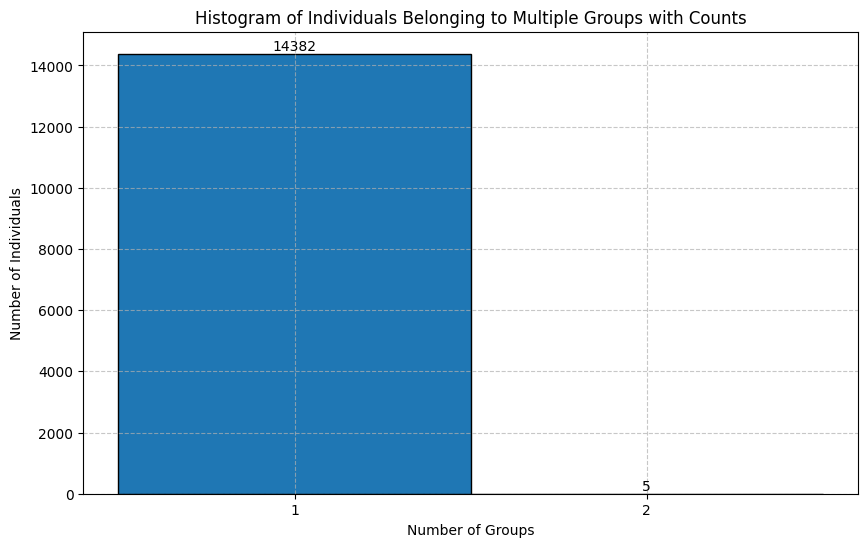

Unique Individuals Ratio: 0.8179544033202569, duplicate : 3202, total: 17589


In [17]:
# Example usage:
individual_col = 'indv_key'
group_col = 'group_key'

unique_ratio, duplicates_count, total = unique_individuals_ratio(data.dataframe, 'indv_key', data.attr_possible_values)
individuals_in_multiple_groups_count = individuals_in_multiple_groups(data.dataframe, individual_col, group_col)

print(f"Unique Individuals Ratio: {unique_ratio}, duplicate : {duplicates_count}, total: {total}")

### Example of a dataset

In [18]:
attr_cols = list(filter(lambda x: 'Attr' in x, data.dataframe.columns))
group_attributes = list(filter(lambda x: 'calculated' in x, data.dataframe.columns))
data.dataframe[['group_key', 'subgroup_key', 'indv_key']+attr_cols+group_attributes]

,group_key,subgroup_key,indv_key,Attr1_X,Attr2_X,Attr3_X,Attr4_X,Attr5_X,Attr1_T,Attr2_T,...,calculated_epistemic_evidential,calculated_similarity,calculated_epistemic_group,calculated_aleatoric_group,calculated_magnitude,calculated_uncertainty_group,calculated_intersectionality,calculated_granularity,calculated_group_size,calculated_subgroup_ratio
1123,*|*|*|*|*|*|*|5|7|*-*|*|*|*|*|*|*|0|0|*,*|*|*|*|*|*|*|0|0|*,0|0|0|0|0|0|0|0|0|0,0,0,0,0,0,0,0,...,0.602722,0.0,0.182550,0.300186,0.248710,0.241368,0.2,0.2,328,0.271457
1073,*|*|*|*|*|*|*|5|7|*-*|*|*|*|*|*|*|0|0|*,*|*|*|*|*|*|*|0|0|*,0|0|0|0|0|0|0|0|0|3,0,0,0,0,0,0,0,...,0.599679,0.0,0.182550,0.300186,0.248710,0.241368,0.2,0.2,328,0.271457
1131,*|*|*|*|*|*|*|5|7|*-*|*|*|*|*|*|*|0|0|*,*|*|*|*|*|*|*|0|0|*,0|0|0|0|0|0|0|1|0|7,0,0,0,0,0,0,0,...,0.614109,0.0,0.182550,0.300186,0.248710,0.241368,0.2,0.2,328,0.271457
1061,*|*|*|*|*|*|*|5|7|*-*|*|*|*|*|*|*|0|0|*,*|*|*|*|*|*|*|0|0|*,0|0|0|0|0|0|0|6|2|0,0,0,0,0,0,0,0,...,0.574353,0.0,0.182550,0.300186,0.248710,0.241368,0.2,0.2,328,0.271457
1133,*|*|*|*|*|*|*|5|7|*-*|*|*|*|*|*|*|0|0|*,*|*|*|*|*|*|*|0|0|*,0|0|0|0|0|0|1|0|0|5,0,0,0,0,0,0,1,...,0.595714,0.0,0.182550,0.300186,0.248710,0.241368,0.2,0.2,328,0.271457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15551,2|2|7|*|3|7|2|*|7|*-1|0|6|*|7|2|3|*|6|*,2|2|7|*|3|7|2|*|7|*,2|2|7|7|3|7|2|6|7|5,2,2,7,7,3,7,2,...,0.805119,0.0,0.193266,0.226332,0.226381,0.209799,0.4,1.0,170,0.100244
15612,2|2|7|*|3|7|2|*|7|*-1|0|6|*|7|2|3|*|6|*,2|2|7|*|3|7|2|*|7|*,2|2|7|8|3|7|2|1|7|4,2,2,7,8,3,7,2,...,0.815296,0.0,0.193266,0.226332,0.226381,0.209799,0.4,1.0,170,0.100244
15558,2|2|7|*|3|7|2|*|7|*-1|0|6|*|7|2|3|*|6|*,2|2|7|*|3|7|2|*|7|*,2|2|7|8|3|7|2|1|7|7,2,2,7,8,3,7,2,...,0.842203,0.0,0.193266,0.226332,0.226381,0.209799,0.4,1.0,170,0.100244
15571,2|2|7|*|3|7|2|*|7|*-1|0|6|*|7|2|3|*|6|*,2|2|7|*|3|7|2|*|7|*,2|2|7|8|3|7|2|2|7|2,2,2,7,8,3,7,2,...,0.797639,0.0,0.193266,0.226332,0.226381,0.209799,0.4,1.0,170,0.100244


In [7]:
def create_parallel_coordinates_plot(data):
    group_properties = data.groupby('group_key').agg({
        'calculated_group_size': 'mean',  # Added group size
        'calculated_granularity': 'mean',
        'calculated_intersectionality': 'mean',
        'calculated_subgroup_ratio': 'mean',
        'calculated_similarity': 'mean',
        'epis_uncertainty': 'mean',
        'alea_uncertainty': 'mean',
        'calculated_magnitude': 'mean'
    }).reset_index().copy()

    for column in group_properties.columns:
        if column != 'group_key':
            group_properties[column] = pd.to_numeric(group_properties[column], errors='coerce')

    # Remove any rows with NaN values
    group_properties = group_properties.dropna()

    # Normalize the data to a 0-1 range for each property
    columns_to_plot = [
        'calculated_group_size',  # Added group size
        'calculated_granularity',
        'calculated_intersectionality',
        'calculated_subgroup_ratio',
        'calculated_similarity',
        'alea_uncertainty',
        'epis_uncertainty',
        'calculated_magnitude'
    ]
    normalized_data = group_properties[columns_to_plot].copy()
    for column in columns_to_plot:
        min_val = normalized_data[column].min()
        max_val = normalized_data[column].max()
        if min_val != max_val:
            normalized_data[column] = (normalized_data[column] - min_val) / (max_val - min_val)
        else:
            normalized_data[column] = 0.5  # Set to middle value if all values are the same

    # Create the plot with increased height for better readability
    fig, ax = plt.subplots(figsize=(15, 8))

    # Create x-coordinates for each property
    x = list(range(len(columns_to_plot)))

    # Create colormap
    norm = Normalize(vmin=group_properties['calculated_magnitude'].min(), vmax=group_properties['calculated_magnitude'].max())
    cmap = plt.get_cmap('viridis')

    # Plot each group
    for i, row in normalized_data.iterrows():
        y = row[columns_to_plot].values
        color = cmap(norm(group_properties.loc[i, 'calculated_magnitude']))
        ax.plot(x, y, c=color, alpha=0.5)

    # Add mean line with different style
    mean_values = normalized_data.mean()
    ax.plot(x, mean_values, 'r--', linewidth=2, label='Mean', alpha=0.8)

    # Customize the plot
    ax.set_xticks(x)
    ax.set_xticklabels(columns_to_plot, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.set_title('Parallel Coordinates Plot of Discrimination Metrics')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Normalized Values')

    # Add gridlines
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Add value ranges in the grid
    for i, column in enumerate(columns_to_plot):
        min_val = group_properties[column].min()
        max_val = group_properties[column].max()
        ax.text(i, -0.1, f'Min: {min_val:.2f}\nMax: {max_val:.2f}',
                ha='center', va='top', fontsize=8)

    # Add colorbar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Calculated Magnitude')

    # Add legend
    ax.legend()

    plt.tight_layout()
    plt.show()

### Parrallel Coordinates showcasing the variability of the groups properties in the simulated dataset

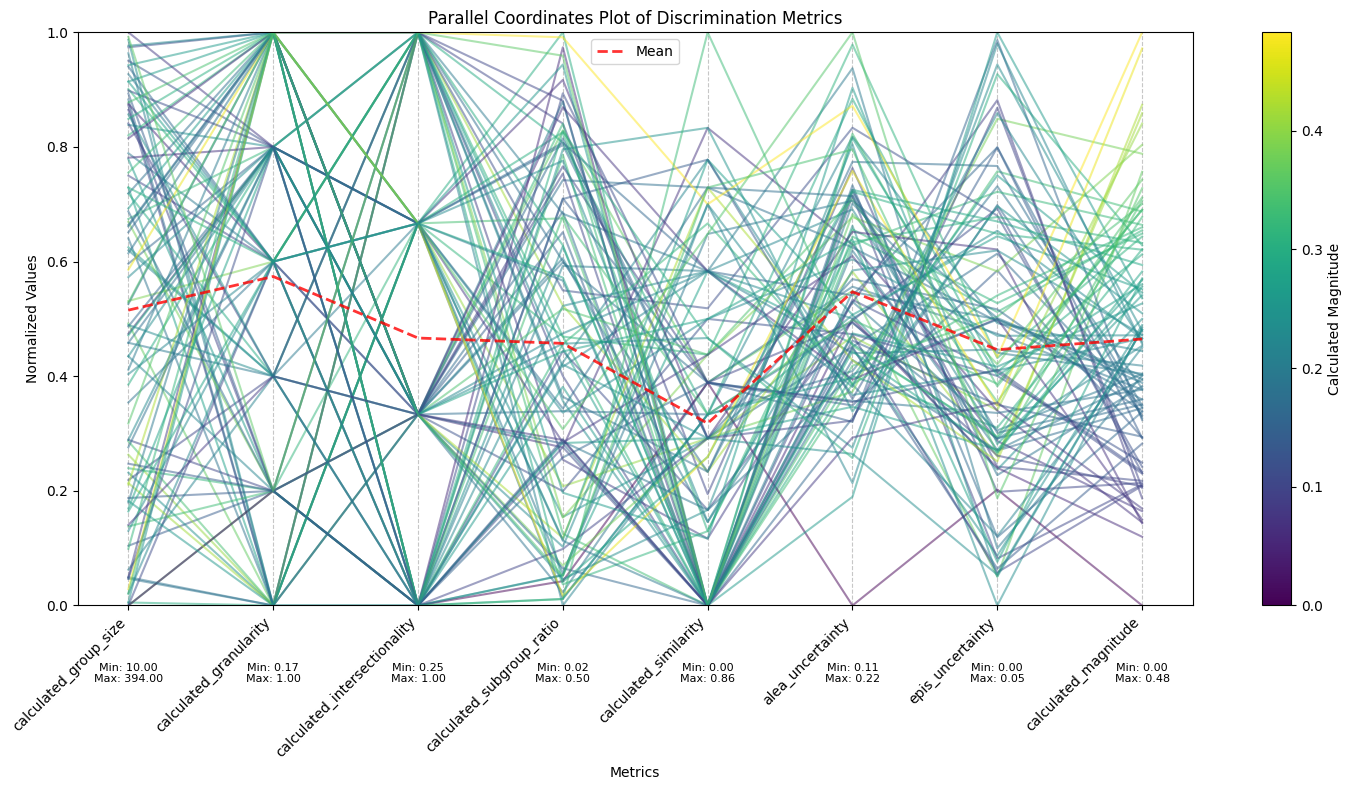

In [8]:
create_parallel_coordinates_plot(data.dataframe)

In [19]:
def plot_and_print_metric_distributions(data, num_bins=10):
    metrics = [
        'calculated_granularity', 'calculated_intersectionality', 'calculated_subgroup_ratio', 'calculated_similarity',
        'calculated_aleatoric_group', 'calculated_epistemic_group', 'calculated_magnitude'
    ]

    group_properties = data.groupby('group_key').agg({metric: 'mean' for metric in metrics}).reset_index()

    # Create a 2x3 subplot layout
    fig, axes = plt.subplots(3, 3, figsize=(18, 12), tight_layout=True)
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    for i, (metric, ax) in enumerate(zip(metrics, axes)):
        # Remove NaN values
        clean_data = group_properties[metric].dropna()

        if clean_data.empty:
            print(f"\nWarning: All values for {metric} are NaN. Skipping this metric.")
            ax.text(0.5, 0.5, f"No valid data for {metric}", ha='center', va='center')
            continue

        try:
            # Determine the number of bins
            unique_values = clean_data.nunique()
            actual_bins = min(num_bins, unique_values)

            # Create histogram
            if actual_bins == unique_values:
                bins = np.sort(clean_data.unique())
            else:
                bins = actual_bins

            n, bins, patches = ax.hist(clean_data, bins=bins, edgecolor='black')

            # Add labels and title
            ax.set_xlabel(metric, fontsize=10)
            ax.set_ylabel('Frequency', fontsize=10)
            ax.set_title(f'Distribution of {metric}', fontsize=12, pad=10)

            # Add percentage labels on top of each bar
            total_count = len(clean_data)
            for j, rect in enumerate(patches):
                height = rect.get_height()
                percentage = height / total_count * 100
                ax.text(rect.get_x() + rect.get_width() / 2., height,
                        f'{percentage:.1f}%',
                        ha='center', va='bottom', rotation=90, fontsize=8)

            # Adjust y-axis to make room for percentage labels
            ax.set_ylim(top=ax.get_ylim()[1] * 1.2)

            # Add mean and median lines
            mean_value = clean_data.mean()
            median_value = clean_data.median()
            ax.axvline(mean_value, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_value:.2f}')
            ax.axvline(median_value, color='green', linestyle=':', alpha=0.7, label=f'Median: {median_value:.2f}')
            ax.legend(fontsize=8)

        except Exception as e:
            print(f"\nError processing {metric}: {str(e)}")
            ax.text(0.5, 0.5, f"Error processing {metric}", ha='center', va='center')

    # Add a main title to the figure
    fig.suptitle('Distribution of Discrimination Properties for the groups', fontsize=14, y=1.02)

    plt.show()


### Distribution of the group properties

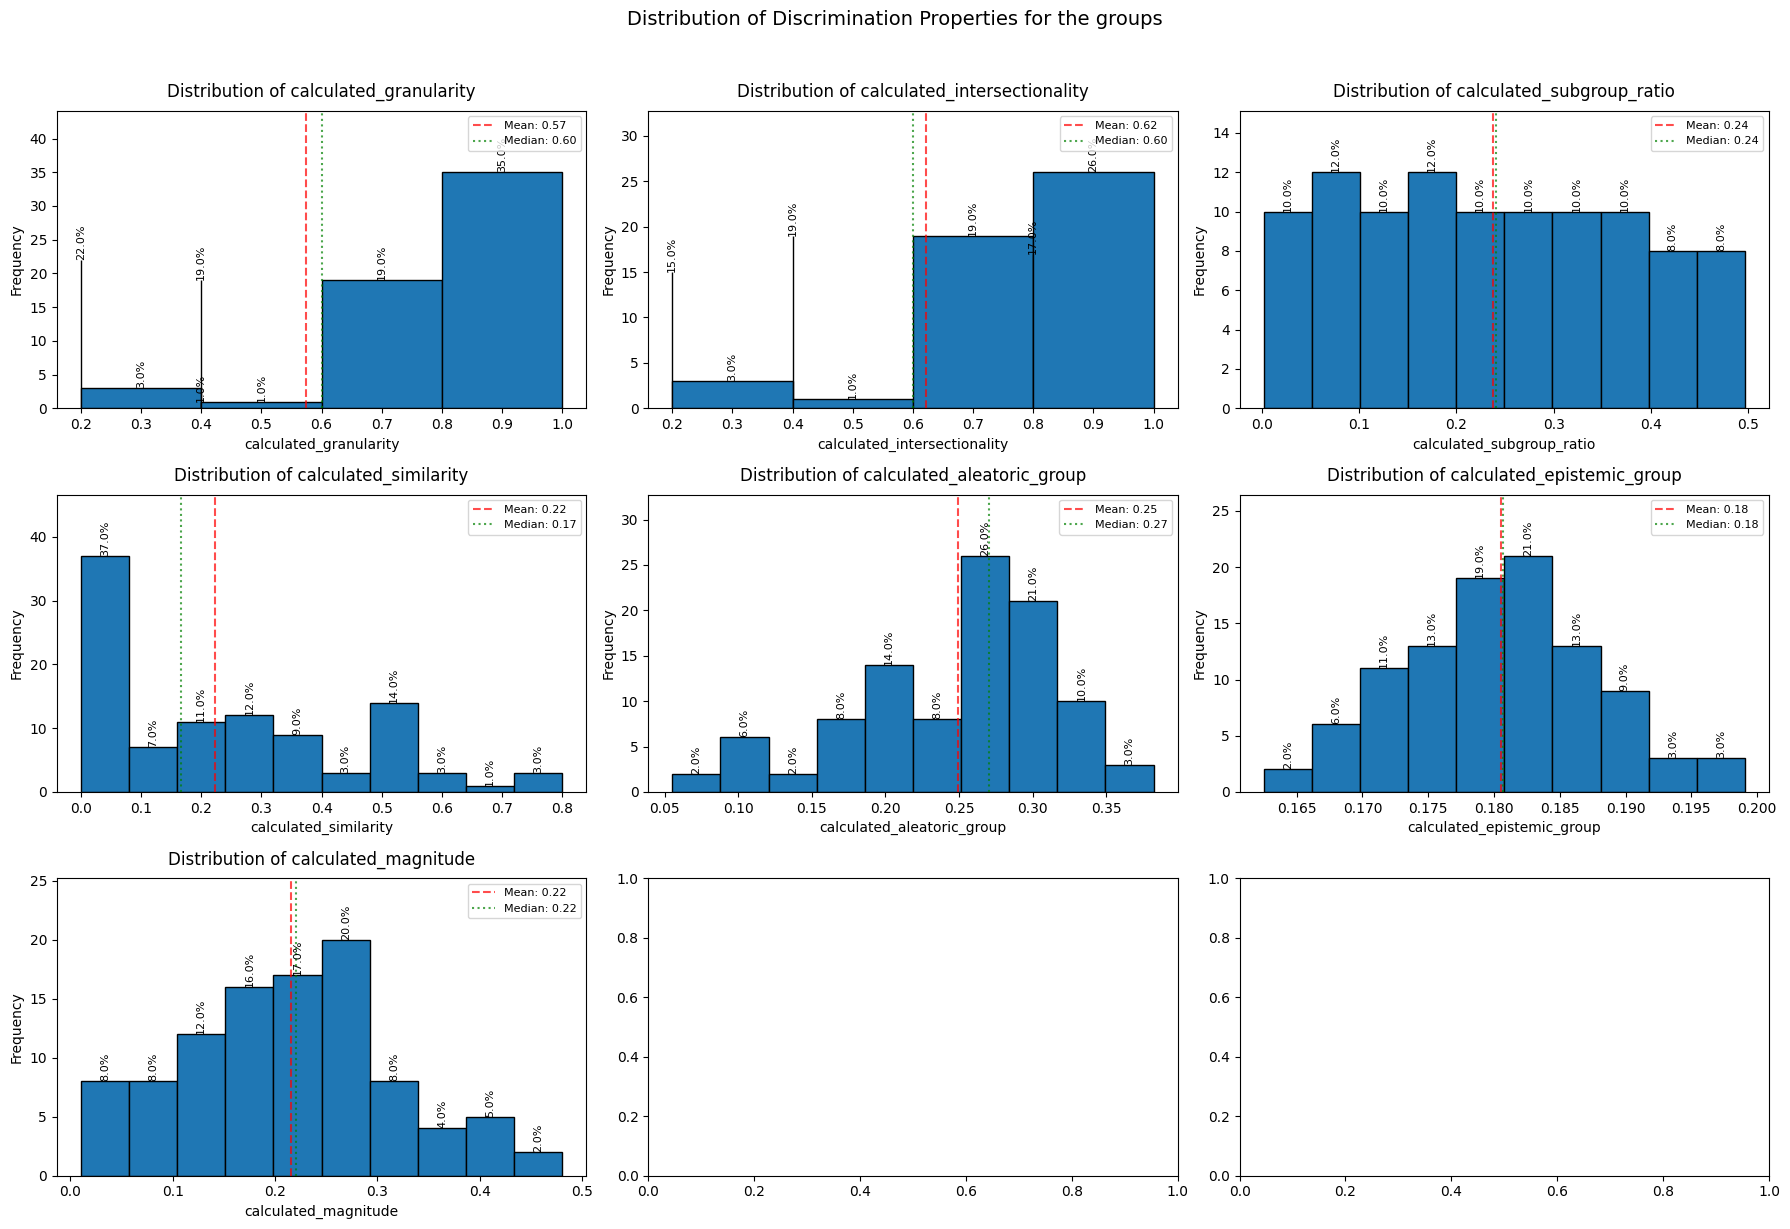

In [20]:
# Usage
plot_and_print_metric_distributions(data.dataframe)

In [11]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

import time
from datetime import datetime
from tqdm.auto import tqdm


def test_models_on_generated_data(data, n_runs=10, test_size=0.2, random_seed=42):
    """
    Comprehensive testing framework for evaluating multiple models across multiple runs.
    """

    # Initialize results storage
    results_list = []

    # Define models to test
    models = {
        'RandomForest': RandomForestClassifier(n_estimators=100),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=100),
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'SVM': SVC(probability=True)
    }

    # Define metrics to evaluate
    def safe_roc_auc(y_true, y_pred_proba):
        try:
            # For binary classification
            if len(np.unique(y_true)) == 2:
                return roc_auc_score(y_true, y_pred_proba[:, 1])
            # For multiclass
            return roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
        except:
            return np.nan

    metrics = {
        'accuracy': accuracy_score,
        'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
        'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted'),
        'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted'),
        'roc_auc': safe_roc_auc
    }

    print("Preparing data...")
    # Extract features and target
    X = data.dataframe[data.feature_names].copy()
    y = data.dataframe[data.outcome_column].copy()

    # Initialize preprocessing objects
    label_encoders = {}
    scaler = StandardScaler()

    # Encode categorical variables
    for column in X.columns:
        if X[column].dtype == 'object':
            le = LabelEncoder()
            X[column] = le.fit_transform(X[column])
            label_encoders[column] = le

    # Encode target variable if categorical
    if y.dtype == 'object':
        print("Encoding target variable...")
        le = LabelEncoder()
        y = le.fit_transform(y)

    # Run multiple tests
    run_pbar = tqdm(range(n_runs), desc="Running test iterations")
    for run in run_pbar:
        current_seed = random_seed + run
        run_results = {
            'run_id': run + 1,
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'seed': current_seed
        }

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=current_seed
        )

        # Scale features
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        for model_name, model in models.items():
            start_time = time.time()

            try:
                # Train model
                model.fit(X_train_scaled, y_train)

                # Get predictions
                y_pred = model.predict(X_test_scaled)
                y_pred_proba = model.predict_proba(X_test_scaled) if hasattr(model, 'predict_proba') else None

                # Calculate metrics

                for metric_name, metric_func in metrics.items():
                    try:
                        if metric_name == 'roc_auc' and y_pred_proba is not None:
                            score = metric_func(y_test, y_pred_proba)
                        else:
                            score = metric_func(y_test, y_pred)
                        run_results[f'{model_name}_{metric_name}'] = score
                    except Exception as e:
                        print(f"\nWarning: Could not calculate {metric_name} for {model_name}: {str(e)}")
                        run_results[f'{model_name}_{metric_name}'] = np.nan

                # Get feature importance if available
                if hasattr(model, 'feature_importances_'):
                    importance = model.feature_importances_
                    top_features = pd.Series(importance, index=X.columns).nlargest(5).index.tolist()
                    run_results[f'{model_name}_top_features'] = ','.join(top_features)

                # Calculate training time
                run_results[f'{model_name}_train_time'] = time.time() - start_time

            except Exception as e:
                print(f"\nError with {model_name}: {str(e)}")
                # Fill with NaN values for failed model
                for metric_name in metrics.keys():
                    run_results[f'{model_name}_{metric_name}'] = np.nan
                run_results[f'{model_name}_train_time'] = np.nan

        results_list.append(run_results)

        # Update run progress bar description with current accuracies
        acc_desc = " | ".join([f"{model}: {run_results.get(f'{model}_accuracy', 0):.3f}"
                               for model in models.keys()])
        run_pbar.set_description(f"Run {run + 1}/{n_runs} | {acc_desc}")

    print("\nComputing summary statistics...")
    # Convert results to DataFrame
    results_df = pd.DataFrame(results_list)

    # Calculate summary statistics
    summary_stats = {}
    for column in results_df.columns:
        if column not in ['run_id', 'timestamp', 'seed'] and not column.endswith('top_features'):
            summary_stats[f'{column}_mean'] = results_df[column].mean()
            summary_stats[f'{column}_std'] = results_df[column].std()
            summary_stats[f'{column}_min'] = results_df[column].min()
            summary_stats[f'{column}_max'] = results_df[column].max()

    summary_df = pd.DataFrame([summary_stats])

    return results_df, summary_df


def visualize_model_comparison(results_df, summary_df):
    """
    Create visualizations to compare model performance.
    """
    print("Generating visualizations...")
    # Create performance comparison plot
    metric_names = ['accuracy', 'f1', 'precision', 'recall']
    model_names = ['RandomForest', 'GradientBoosting', 'LogisticRegression', 'SVM']

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, metric in enumerate(metric_names):
        ax = axes[i]
        data = []
        labels = []

        for model in model_names:
            col_name = f'{model}_{metric}'
            if col_name in results_df.columns:
                data.append(results_df[col_name].values)
                labels.append(model)

        if data:  # Only create plot if we have data
            ax.boxplot(data, labels=labels)
            ax.set_title(f'{metric.capitalize()} Comparison')
            ax.set_ylabel('Score')
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics:")
    print(summary_df.round(4).to_string())

    return fig


def run_model_comparison(data, n_runs=10):
    """
    Run the complete model comparison analysis.
    """
    print(f"Starting model comparison with {n_runs} runs...")
    results_df, summary_df = test_models_on_generated_data(data, n_runs=n_runs)

    visualize_model_comparison(results_df, summary_df)

    return results_df, summary_df

### Performance of the predictability of models on the dataset

Starting model comparison with 2 runs...
Preparing data...
Run 2/2 | RandomForest: 0.748 | GradientBoosting: 0.582 | LogisticRegression: 0.503 | SVM: 0.628: 100%|██████████| 2/2 [02:00<00:00, 60.23s/it]

Computing summary statistics...
Generating visualizations...


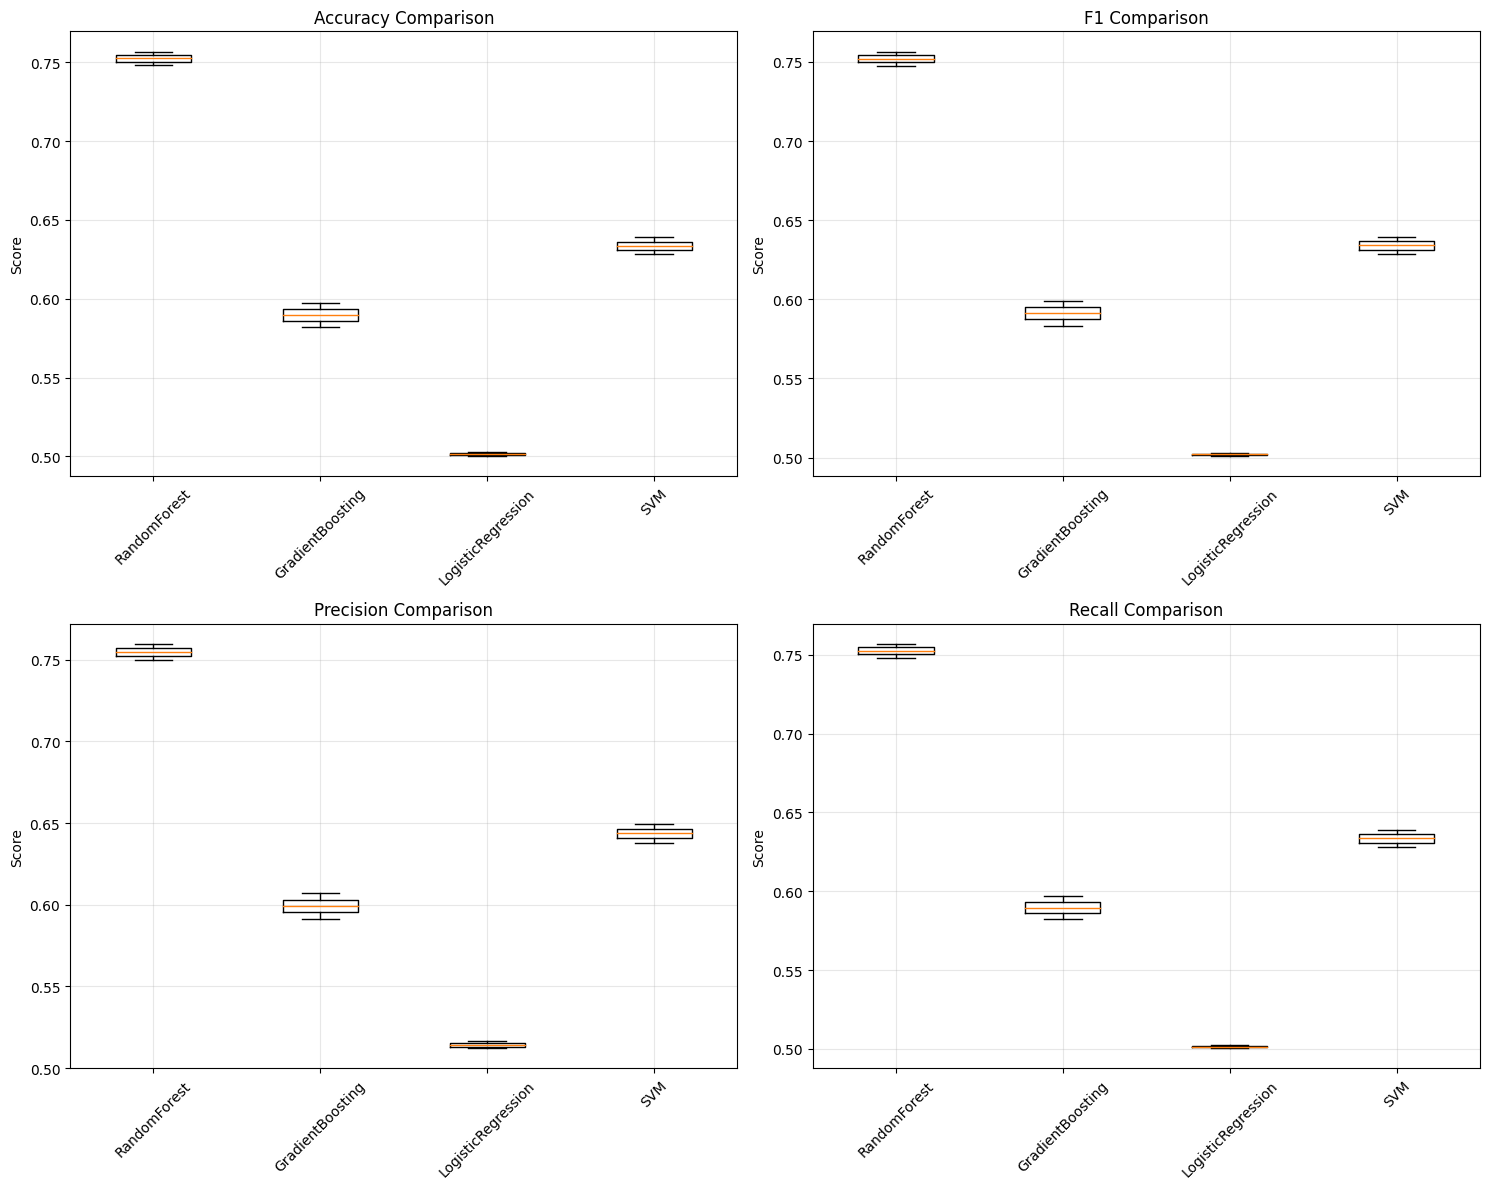


Summary Statistics:
   RandomForest_accuracy_mean  RandomForest_accuracy_std  RandomForest_accuracy_min  RandomForest_accuracy_max  RandomForest_f1_mean  RandomForest_f1_std  RandomForest_f1_min  RandomForest_f1_max  RandomForest_precision_mean  RandomForest_precision_std  RandomForest_precision_min  RandomForest_precision_max  RandomForest_recall_mean  RandomForest_recall_std  RandomForest_recall_min  RandomForest_recall_max  RandomForest_roc_auc_mean  RandomForest_roc_auc_std  RandomForest_roc_auc_min  RandomForest_roc_auc_max  RandomForest_train_time_mean  RandomForest_train_time_std  RandomForest_train_time_min  RandomForest_train_time_max  GradientBoosting_accuracy_mean  GradientBoosting_accuracy_std  GradientBoosting_accuracy_min  GradientBoosting_accuracy_max  GradientBoosting_f1_mean  GradientBoosting_f1_std  GradientBoosting_f1_min  GradientBoosting_f1_max  GradientBoosting_precision_mean  GradientBoosting_precision_std  GradientBoosting_precision_min  GradientBoosting_precis

In [12]:
results_df, summary_df = run_model_comparison(data, n_runs=2)

In [13]:
from scipy.spatial.distance import cosine

def plot_correlation_matrices(input_correlation_matrix, generated_data, figsize=(30, 10)):
    attr_columns = [col for col in generated_data.dataframe.columns if col.startswith('Attr')]
    generated_correlation_matrix = generated_data.dataframe[attr_columns].corr(method='spearman')
    
    assert input_correlation_matrix.shape == generated_correlation_matrix.shape, "Correlation matrices have different shapes"
    
    if isinstance(input_correlation_matrix, np.ndarray):
        input_correlation_matrix = pd.DataFrame(input_correlation_matrix, columns=attr_columns, index=attr_columns)
    
    # Calculate similarity metrics
    frobenius = np.linalg.norm(input_correlation_matrix - generated_correlation_matrix)
    cosine_sim = 1 - cosine(input_correlation_matrix.values.flatten(), 
                           generated_correlation_matrix.values.flatten())
    mse = np.mean((input_correlation_matrix - generated_correlation_matrix) ** 2)
    correlation = np.corrcoef(input_correlation_matrix.values.flatten(), 
                            generated_correlation_matrix.values.flatten())[0,1]
    
    # Calculate the absolute difference matrix
    abs_diff_matrix = np.abs(input_correlation_matrix - generated_correlation_matrix)
    
    # Create custom colormap
    colors = ['#053061', '#2166AC', '#4393C3', '#92C5DE', '#D1E5F0', '#FDDBC7', '#F4A582', '#D6604D', '#B2182B']
    n_bins = 256
    custom_cmap = LinearSegmentedColormap.from_list('custom_blue_red', colors, N=n_bins)
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    
    def plot_heatmap(data, ax, title, cmap='coolwarm', vmin=-1, vmax=1):
        sns.heatmap(data, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, center=0,
                    annot=True, fmt='.2f', square=True, cbar=False,
                    annot_kws={'size': 11}, linewidths=0.5)
        ax.set_title(title, fontsize=16, pad=20)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)
    
    # Plot matrices
    plot_heatmap(input_correlation_matrix, ax1, 'Input Correlation Matrix')
    plot_heatmap(generated_correlation_matrix, ax2, 'Generated Data Correlation Matrix')
    plot_heatmap(abs_diff_matrix, ax3, 'Absolute Difference Matrix', cmap=custom_cmap, vmin=0, vmax=1)
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=10)
    
    # Adjust layout and display
    plt.tight_layout(rect=[0, 0, 0.92, 1])
    plt.show()
    
    # Print all similarity metrics
    print("\nMatrix Similarity Metrics:")
    print(f"Mean absolute difference: {np.mean(abs_diff_matrix):.4f}")
    print(f"Maximum absolute difference: {np.max(abs_diff_matrix):.4f}")
    print(f"Frobenius norm: {frobenius:.4f}")
    print(f"Cosine similarity: {cosine_sim:.4f}")
    print(f"Mean squared error: {mse:.4f}")
    print(f"Correlation coefficient: {correlation:.4f}")

### Capacity to follow the correlation matrix

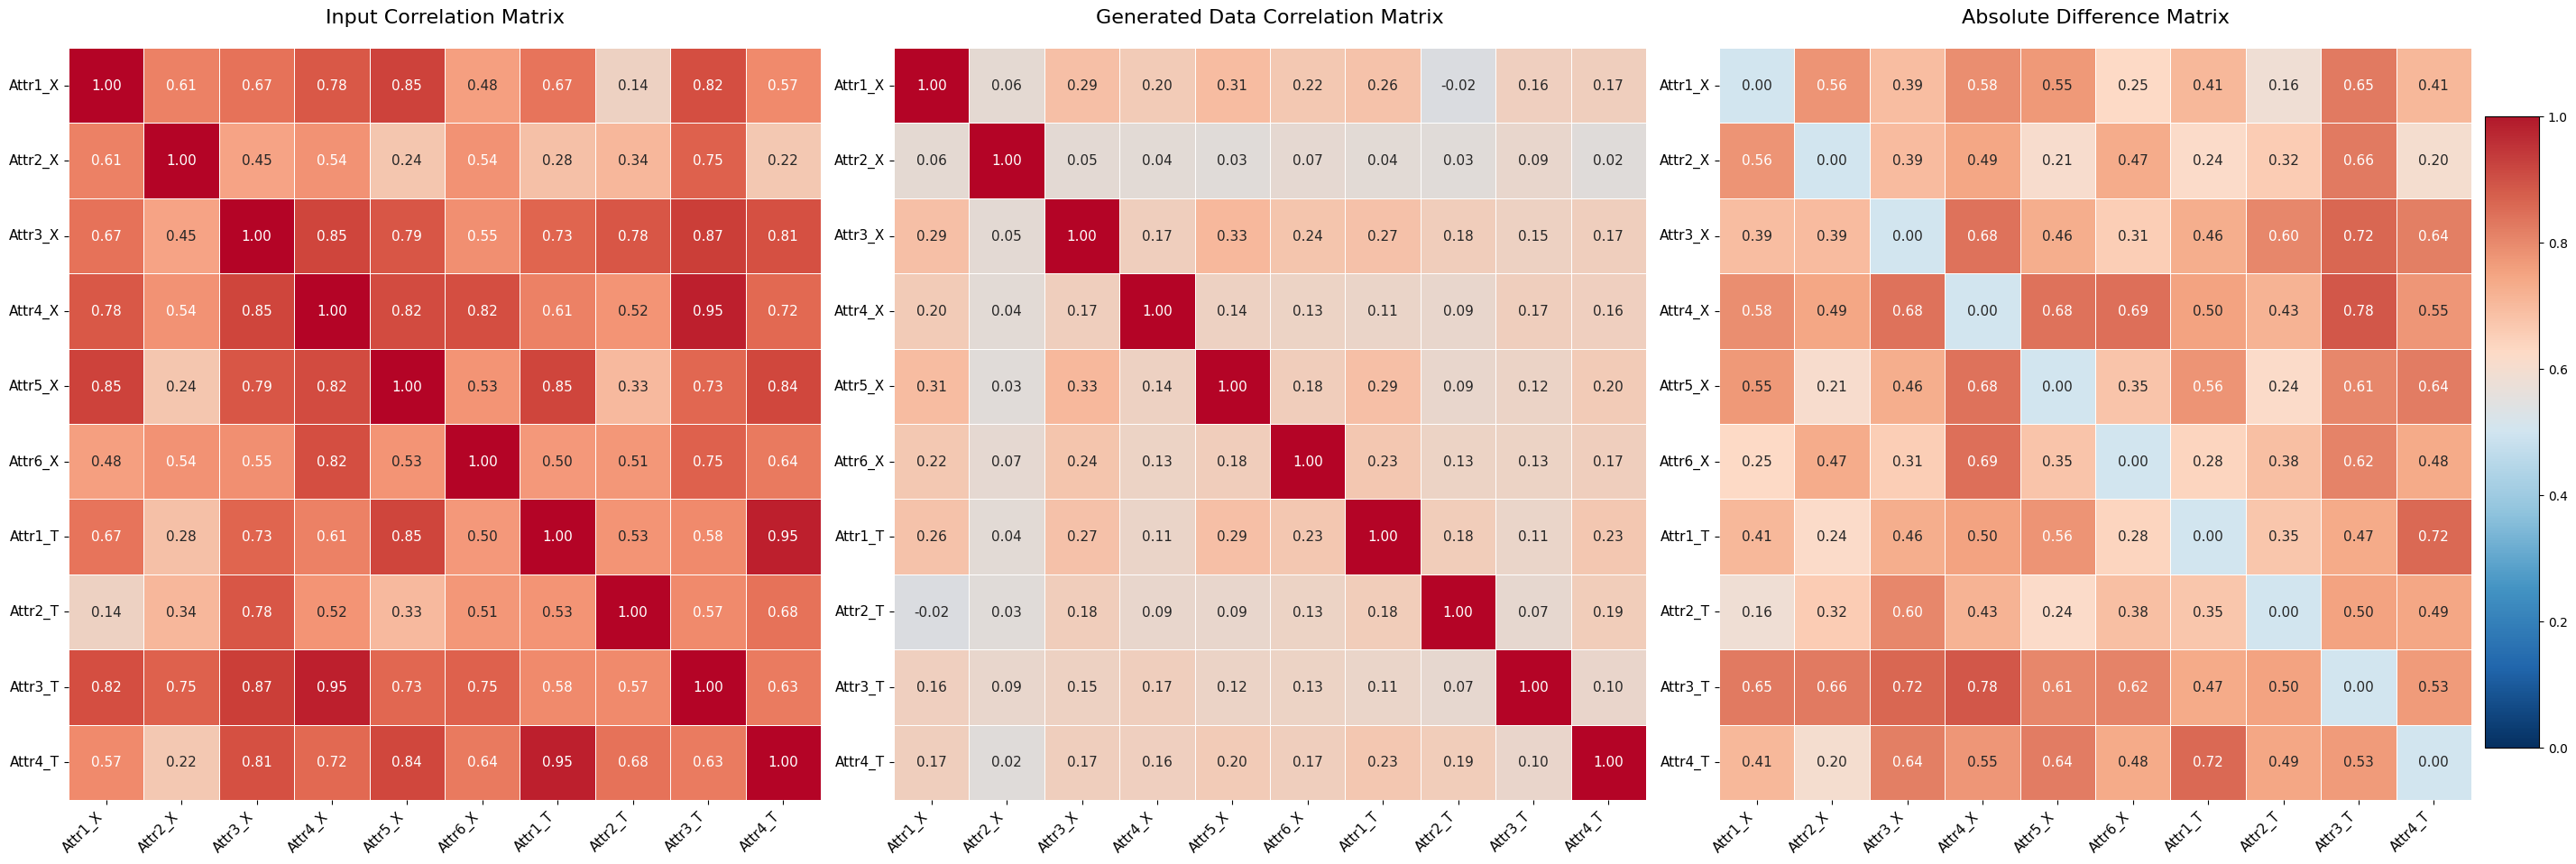


Matrix Similarity Metrics:
Mean absolute difference: 0.4331
Maximum absolute difference: 0.7787
Frobenius norm: 4.8041
Cosine similarity: 0.7780
Mean squared error: 0.2308
Correlation coefficient: 0.6477


In [14]:
plot_correlation_matrices(correlation_matrix, data)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ac560f7a-a215-45b2-bdc4-8c0a3d83faaf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>